# Contextual Bandits with Fairness Analysis

## Resampled dataset

In [1]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB

# === 1. Load and prepare data ===
df = pd.read_csv("../../data/Xy_train_resampled.csv")

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3, random_state=42)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  # needs 2D input
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.484


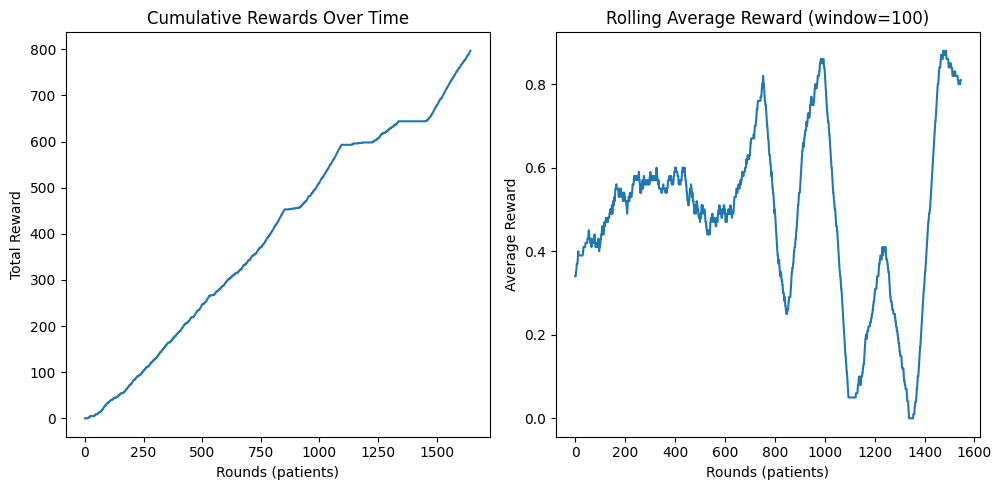

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = (preds == y).astype(int)  # 1 = correct prediction, 0 = incorrect

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward 
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [3]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.41847826086956524


In [4]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.88      0.63      0.74        82
           1       0.52      0.32      0.40        53
           2       0.11      0.18      0.13        22
           3       0.04      0.05      0.04        21
           4       0.10      0.50      0.17         6

    accuracy                           0.42       184
   macro avg       0.33      0.34      0.30       184
weighted avg       0.56      0.42      0.47       184



### Fairness evaluation on test data

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, f1_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test       
X_test["true"] = y_test  

# Protected attribute
protected_attr = "sex_Male"  
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    n_samples = len(group_df)
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro")  
    f1 = f1_score(group_df["true"], group_df["pred"], average="macro")  
    label = "Male" if g == 1 else "Female"
    metrics[label] = {
        "accuracy": round(acc, 4),
        "recall": round(rec, 4),
        "f1": round(f1, 4),
        "n_samples": int(n_samples)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# save
import json

with open("../../results/cb_gender_resampled.json", "w") as f:
    json.dump(metrics_df.to_dict(), f, indent=4)


        accuracy  recall      f1  n_samples
Male      0.3618  0.3257  0.2906      152.0
Female    0.6875  0.2056  0.2480       32.0


/home/aniqu/.conda/envs/fairness-analysis-rl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Statistical significance test

In [6]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.394, p = 0.00069
accuracy difference significant


## Original dataset

In [7]:
import pandas as pd
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.preprocessing import StandardScaler

# === 1. Load and prepare data ===
X_train = pd.read_csv('../../data/X_train.csv')
y_train = pd.read_csv('../../data/y_train.csv')
df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

X = df.drop(columns=['num']).values
y = df['num'].astype(int).values

# === 2. Initialize contextual bandit policy ===
n_actions = len(np.unique(y))  # type: ignore # should be 5 (0–4)
policy = LinUCB(nchoices=n_actions, alpha=0.3, random_state=42)

# === 3. Simulate online learning ===
preds, rewards = [], []

for i in range(len(X)):
    x_i = X[i].reshape(1, -1)  
    true_label = y[i]

    # Predict (returns action indices)
    chosen_action = policy.predict(x_i)[0] # type: ignore

    # Reward: 1 if correct, else 0
    reward = int(chosen_action == true_label)

    # Update policy with this sample
    policy.partial_fit(x_i, np.array([chosen_action]), np.array([reward]))

    preds.append(chosen_action)
    rewards.append(reward)

# === 4. Store results ===
results = pd.DataFrame({
    "true_label": y,
    "predicted": preds,
    "reward": rewards
})

print("✅ Simulation complete")
print(f"Approx. accuracy on train data: {np.mean(results['true_label'] == results['predicted']):.3f}")


✅ Simulation complete
Approx. accuracy on train data: 0.492


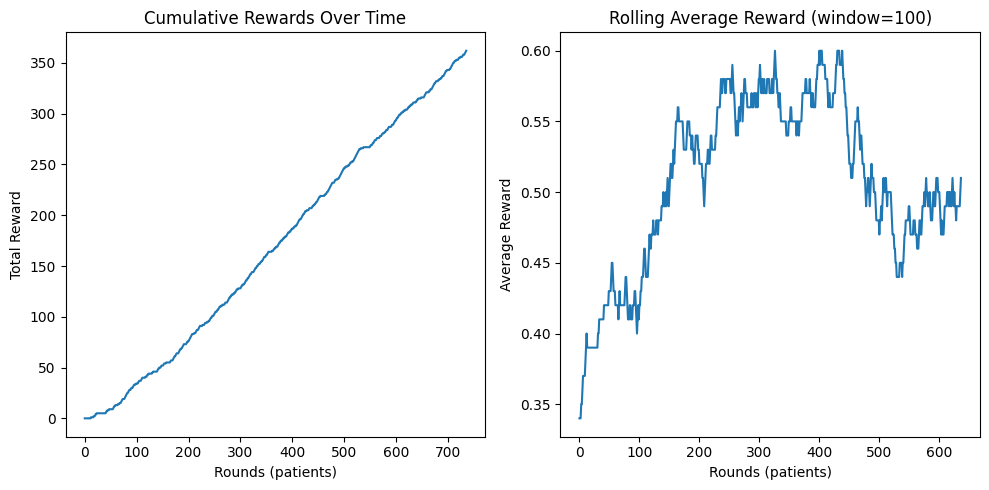

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rewards = (preds == y).astype(int)  

# Cumulative rewards over time
cumulative_rewards = np.cumsum(rewards)

# Rolling average reward
window = 100
rolling_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Rounds (patients)")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(rolling_avg)
plt.title(f"Rolling Average Reward (window={window})")
plt.xlabel("Rounds (patients)")
plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()



In [9]:
from sklearn.metrics import accuracy_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)

score = accuracy_score(y_test, preds_test)

print("accuracy on test data: ", score)


accuracy on test data:  0.5217391304347826


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        82
           1       0.42      0.47      0.45        53
           2       0.00      0.00      0.00        22
           3       0.20      0.29      0.24        21
           4       0.00      0.00      0.00         6

    accuracy                           0.52       184
   macro avg       0.28      0.31      0.29       184
weighted avg       0.50      0.52      0.51       184



### Fairness evaluation on test data

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

X_test = pd.read_csv('../../data/X_test.csv')
y_test = pd.read_csv('../../data/y_test.csv')

preds_test = policy.predict(X_test)


X_test["pred"] = preds_test      
X_test["true"] = y_test  

# Protected attribute
protected_attr = "sex_Male"  
groups = X_test[protected_attr].unique()

metrics = {}
for g in groups:
    group_df = X_test[X_test[protected_attr] == g]
    n_samples = len(group_df)
    acc = accuracy_score(group_df["true"], group_df["pred"])
    rec = recall_score(group_df["true"], group_df["pred"], average="macro") 
    f1 = f1_score(group_df["true"], group_df["pred"], average="macro")  
    label = "Male" if g == 1 else "Female"
    metrics[label] = {
        "accuracy": round(acc, 4),
        "recall": round(rec, 4),
        "f1": round(f1, 4),
        "n_samples": int(n_samples)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# save
with open("../../results/cb_gender_original.json", "w") as f:
    json.dump(metrics_df.to_dict(), f, indent=4)

        accuracy  recall      f1  n_samples
Male      0.4605  0.3006  0.2859      152.0
Female    0.8125  0.2940  0.3029       32.0


/opt/miniconda3/envs/fariness-analysis-rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [13]:
X_test.groupby("sex_Male")["true"].value_counts()

sex_Male  true
0         0       27
          1        4
          2        1
1         0       55
          1       49
          2       21
          3       21
          4        6
Name: count, dtype: int64

In [14]:
print(X_test.groupby(["sex_Male", "pred"])["pred"].count())


sex_Male  pred
0         0       27
          1        3
          3        2
1         0       55
          1       56
          2        5
          3       28
          4        8
Name: pred, dtype: int64


#### Statistical significance

In [15]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


male_mask = X_test["sex_Male"] == 1
female_mask = X_test["sex_Male"] == 0


y_true_male = y_test[male_mask]
y_pred_male = preds_test[male_mask]
y_true_female = y_test[female_mask]
y_pred_female = preds_test[female_mask]

assert((len(y_true_male) + len(y_true_female)) == (len(y_pred_male) + len(y_pred_female)))

acc_male = (y_pred_male == y_true_male.to_numpy().ravel()).astype(int)
acc_female = (y_pred_female == y_true_female.to_numpy().ravel()).astype(int)


count = np.array([acc_male.sum(), acc_female.sum()])  # number of correct predictions
nobs = np.array([len(acc_male), len(acc_female)])      # group sizes

stat, pval = proportions_ztest(count, nobs)
print(f"z = {stat:.3f}, p = {pval:.5f}")

if pval < 0.05:
    print('accuracy difference significant')


z = -3.623, p = 0.00029
accuracy difference significant


## With age groups (original dataset)

In [16]:
df = pd.read_csv('../../data/age_analysis/Xy_test_age_analysis.csv')
df.rename(columns={'num':'true'}, inplace=True)
df['pred'] = preds_test

In [17]:
from sklearn.metrics import accuracy_score, recall_score

results = {}

for group in df['age_group'].unique():
    mask = df['age_group'] == group
    y_true = df.loc[mask, 'true']
    y_pred = df.loc[mask, 'pred']

    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    n_samples = len(y_true)

    results[group] = {'accuracy': acc, 'recall': rec, 'f1': f1, 'n_samples': n_samples}

age_results = pd.DataFrame(results).T
order = [0, 3, 2, 1]
age_results_ordered = age_results.iloc[order]
print(age_results_ordered)

with open("../../results/cb_age_original.json", "w") as f:
    json.dump(age_results_ordered.to_dict(), f, indent=4)


       accuracy    recall        f1  n_samples
<40    0.777778  0.708333  0.723077       18.0
40-50  0.777778  0.346465  0.324242       36.0
50-60  0.525000  0.353968  0.324726       80.0
60+    0.240000  0.188156  0.188444       50.0


/opt/miniconda3/envs/fariness-analysis-rl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Test significance

In [18]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import itertools
import json

age_groups = ["<40", "40-50", "50-60", "60+"]
results = []

for g1, g2 in itertools.combinations(age_groups, 2):
    mask_1 = df["age_group"] == g1
    mask_2 = df["age_group"] == g2

    y_true_1 = df.loc[mask_1, "true"]
    y_pred_1 = df.loc[mask_1, "pred"]
    y_true_2 = df.loc[mask_2, "true"]
    y_pred_2 = df.loc[mask_2, "pred"]

    acc_1 = (y_pred_1.to_numpy() == y_true_1.to_numpy()).astype(int)
    acc_2 = (y_pred_2.to_numpy() == y_true_2.to_numpy()).astype(int)

    count = np.array([acc_1.sum(), acc_2.sum()])
    nobs = np.array([len(acc_1), len(acc_2)])
    stat, pval = proportions_ztest(count, nobs)

    acc_rate_1 = acc_1.mean()
    acc_rate_2 = acc_2.mean()
    
    result = {
        "comparison": f"{g1} vs {g2}",
        "accuracy_1": f"{acc_rate_1:.6f}",
        "accuracy_2": f"{acc_rate_2:.6f}",
        "z_stat": f"{stat:.6f}",
        "p_value": f"{pval:.8f}",
        "significant": bool(pval < 0.05)
    }
    results.append(result)

    # print to console
    symbol = "✅" if pval < 0.05 else "❌"
    print(f"{g1} vs {g2}: z = {stat:.4f}, p = {pval:.6f} → {symbol} ")

with open("../../results/cb_age_original_significance.json", "w") as f:
    json.dump(results, f, indent=2)


<40 vs 40-50: z = 0.0000, p = 1.000000 → ❌ 
<40 vs 50-60: z = 1.9580, p = 0.050229 → ❌ 
<40 vs 60+: z = 4.0259, p = 0.000057 → ✅ 
40-50 vs 50-60: z = 2.5748, p = 0.010031 → ✅ 
40-50 vs 60+: z = 4.9326, p = 0.000001 → ✅ 
50-60 vs 60+: z = 3.2081, p = 0.001336 → ✅ 


## Graphs

In [19]:
df

,age,trestbps,chol,fbs,thalch,exang,oldpeak,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,age_group,true,pred
0,-1.646666,-1.235320,-0.110571,0,0.489727,1,0.138764,1,0,0,0,1,0,1,0,<40,1,1
1,0.795061,-0.398267,-0.110571,0,-1.300850,1,-0.806886,1,0,0,0,1,0,0,0,60+,3,1
2,0.901224,-0.677285,0.169584,0,-1.778337,1,-0.806886,1,1,0,0,0,0,1,0,60+,1,2
3,0.370413,1.833874,0.845818,1,-0.544828,0,0.138764,1,0,0,0,0,0,1,0,50-60,4,2
4,1.644358,-0.119250,0.498041,0,0.091821,0,-0.334061,1,0,1,0,0,0,1,0,60+,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.266559,-0.398267,-0.622577,0,-0.505038,1,0.517024,1,0,0,1,0,0,0,1,50-60,0,3
180,0.158089,1.554856,0.903781,1,0.211193,1,1.084414,1,1,0,0,1,0,1,0,50-60,1,3
181,0.795061,0.996821,-0.110571,0,-0.823363,1,1.084414,1,0,0,0,1,0,1,0,60+,2,1
182,0.370413,0.438786,-0.110571,0,-0.703991,1,1.084414,1,0,0,0,1,0,1,0,50-60,2,1


In [20]:
df['sex_Male'].values 

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1])

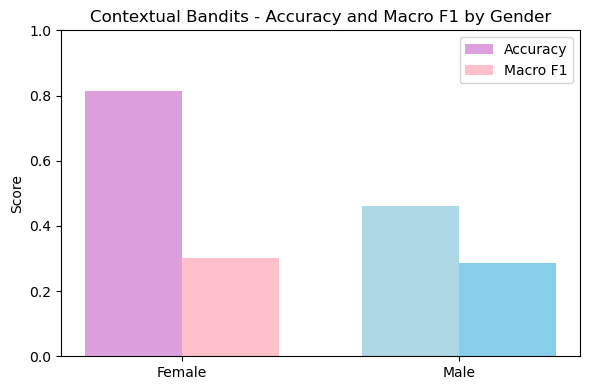

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


df_test = df.copy()

test_sex = df_test['sex_Male'].values 

colors = ['violet', 'cornflowerblue']

if 'sex_Male' in df_test.columns:
    sex_groups = ['Female', 'Male']

    # Compute Accuracy
    acc = [
        accuracy_score(df_test['true'][df_test['sex_Male']==0], df_test['pred'][df_test['sex_Male']==0]),
        accuracy_score(df_test['true'][df_test['sex_Male']==1], df_test['pred'][df_test['sex_Male']==1])
    ]

    # Compute Macro F1
    f1 = [
        f1_score(df_test['true'][df_test['sex_Male']==0], df_test['pred'][df_test['sex_Male']==0], average='macro'),
        f1_score(df_test['true'][df_test['sex_Male']==1], df_test['pred'][df_test['sex_Male']==1], average='macro')
    ]

    # Colors
    colors_acc = ['plum', 'lightblue']
    colors_f1  = ['pink', 'skyblue']

    # Plot grouped bar chart
    x = np.arange(len(sex_groups))
    width = 0.35
    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, acc, width, color=colors_acc, label='Accuracy') # type: ignore
    plt.bar(x + width/2, f1, width, color=colors_f1, label='Macro F1') # type: ignore
    plt.xticks(x, sex_groups)
    plt.ylim(0,1)
    plt.ylabel("Score")
    plt.title("Contextual Bandits - Accuracy and Macro F1 by Gender")
    plt.legend()
    plt.tight_layout()
    plt.show()

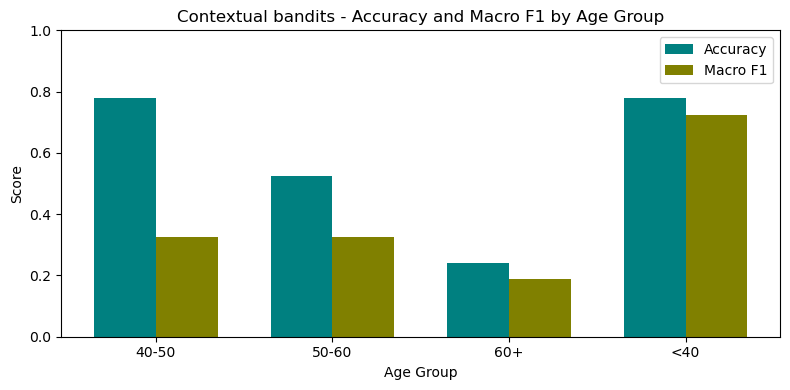

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

NUM_ACTIONS = 5

# Load age analysis file
df_age = pd.read_csv("../../data/age_analysis/Xy_test_age_analysis.csv").rename(columns={"num": "true"})
df_age['pred'] = df_test["pred"]
age_groups = sorted(df_age['age_group'].unique())
acc_by_age = []
f1_by_age = []
cum_correct_by_age = []
pred_rates_by_age = []

for g in age_groups:
        mask = df_age['age_group'] == g
        y_true = df_age.loc[mask, 'true']
        y_pred = df_age.loc[mask, 'pred']

        acc_by_age.append(accuracy_score(y_true, y_pred)) 
        f1_by_age.append(f1_score(y_true, y_pred, average='macro')) 
        cum_correct_by_age.append(np.cumsum((y_pred==y_true).astype(int))) 
        pred_rates_by_age.append([(y_pred==c).mean() for c in range(NUM_ACTIONS)]) 


age_colors = plt.cm.viridis(np.linspace(0.3,0.8,len(age_groups)))


x = np.arange(len(age_groups))
width = 0.35
plt.figure(figsize=(8,4))
plt.bar(x - width/2, acc_by_age, width, label="Accuracy", color='teal')
plt.bar(x + width/2, f1_by_age, width, label="Macro F1", color='olive')

plt.xticks(x, age_groups)
plt.ylim(0,1)
plt.xlabel("Age Group")
plt.ylabel("Score")
plt.title("Contextual bandits - Accuracy and Macro F1 by Age Group")
plt.legend()
plt.tight_layout()
plt.show()




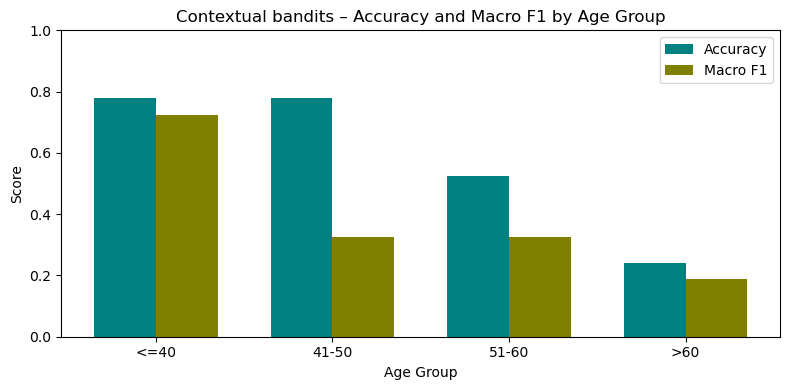

In [ ]:
# Desired age order and display names
desired_order = ["<40", "40-50", "50-60", "60+"]
display_names = {
    "<40": "<=40",
    "40-50": "41-50",
    "50-60": "51-60",
    "60+": ">60",
}

age_groups = [g for g in desired_order if g in df_age['age_group'].unique()]

acc_by_age = []
f1_by_age = []
cum_correct_by_age = []
pred_rates_by_age = []

for g in age_groups:
    mask = df_age['age_group'] == g
    y_true = df_age.loc[mask, 'true']
    y_pred = df_age.loc[mask, 'pred']

    acc_by_age.append(accuracy_score(y_true, y_pred))
    f1_by_age.append(f1_score(y_true, y_pred, average='macro'))
    cum_correct_by_age.append(np.cumsum((y_pred==y_true).astype(int)))
    pred_rates_by_age.append([(y_pred==c).mean() for c in range(NUM_ACTIONS)])

age_colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(age_groups)))

# === Plot ===
x = np.arange(len(age_groups))
width = 0.35
plt.figure(figsize=(8, 4))
plt.bar(x - width/2, acc_by_age, width, label="Accuracy", color='teal')
plt.bar(x + width/2, f1_by_age, width, label="Macro F1", color='olive')

# Apply display names to ticks
plt.xticks(x, [display_names[g] for g in age_groups])
plt.ylim(0, 1)
plt.xlabel("Age Group")
plt.ylabel("Score")
plt.title("Contextual bandits – Accuracy and Macro F1 by Age Group")
plt.legend()
plt.tight_layout()
plt.show()


## Train dataset analysis

## Original

In [19]:
df = pd.read_csv('../../data/X_train.csv')
sex = df['sex_Male']
sex.value_counts()

sex_Male
1    574
0    162
Name: count, dtype: int64

In [20]:
y = pd.read_csv('../../data/y_train.csv')
df['True'] = y

print('males')
print(df[df['sex_Male'] == 1]['True'].value_counts(normalize=True))

print()

print('females')
print(df[df['sex_Male'] == 0]['True'].value_counts(normalize=True))

males
True
0    0.369338
1    0.324042
3    0.135889
2    0.135889
4    0.034843
Name: proportion, dtype: float64

females
True
0    0.722222
1    0.160494
2    0.055556
3    0.049383
4    0.012346
Name: proportion, dtype: float64


In [23]:
age_analysis = pd.read_csv('../../data/age_analysis/Xy_train_age_analysis_with_groups.csv')
df['age_group'] = age_analysis['age_group']
df

,age,trestbps,chol,fbs,thalch,exang,oldpeak,sex_Male,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,True,age_group
0,-0.054235,-0.677285,-0.110571,0,-1.698756,0,-0.806886,1,1,0,0,1,0,1,0,3,50-60
1,2.175168,-0.119250,-0.110571,0,0.091821,0,-0.334061,1,0,1,0,1,0,1,0,0,60+
2,-0.054235,-0.119250,-0.110571,0,-0.107132,1,0.138764,1,0,0,0,0,0,1,0,2,50-60
3,0.901224,-0.956303,-0.110571,0,-2.613939,1,-1.279711,1,0,0,0,1,0,1,0,1,60+
4,0.901224,1.443249,-1.453380,0,0.012240,1,-0.806886,1,0,0,0,0,1,1,0,1,60+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,-0.903531,-1.235320,0.362794,0,-0.226504,0,0.327894,1,0,0,1,1,0,1,0,1,40-50
732,-0.478883,-0.119250,0.459399,0,1.007005,0,-0.806886,0,0,0,0,1,0,0,1,0,40-50
733,0.051927,-0.454071,0.401436,0,-1.141687,1,1.273544,1,0,0,0,0,0,1,0,1,50-60
734,0.476575,0.996821,0.729892,1,0.967214,0,0.138764,0,0,0,1,0,0,0,1,0,50-60


In [24]:
print('<=40')
print(df[df['age_group'] == '<40']['True'].value_counts(normalize=True))

print()

print('60+')
print(df[df['age_group'] == '60+']['True'].value_counts(normalize=True))

<=40
True
0    0.653333
1    0.253333
3    0.040000
2    0.040000
4    0.013333
Name: proportion, dtype: float64

60+
True
0    0.274854
3    0.251462
1    0.233918
2    0.187135
4    0.052632
Name: proportion, dtype: float64


## Resambled

In [102]:
df_resampled = pd.read_csv('../../data/Xy_train_resampled.csv')
sex_resampled = df_resampled['sex_Male']
sex_resampled.value_counts()

sex_Male
1    1347
0     298
Name: count, dtype: int64